# Background

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. From operational standpoint we have been facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

#Data Description
Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers

X1 = my order was delivered on time

X2 = contents of my order was as I expected

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier

X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

In [1]:
#importing libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras import layers, Sequential, optimizers, Input, Model

In [2]:
df = pd.read_csv('/content/ACME-HappinessSurvey2020.csv')
print(df.head())
print(df.shape)

   Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5
(126, 7)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [4]:
# rename columns to a user readable format
old_name = list(df.columns)
new_name = ['happiness', 'order_satisfaction', 'order_completed', 'price_satisfaction',
            'courier_satisfaction', 'app_satisfaction','delivered_time']

df.rename(columns = (dict(zip(old_name, new_name))), inplace = True)
df.head()

,happiness,order_satisfaction,order_completed,price_satisfaction,courier_satisfaction,app_satisfaction,delivered_time
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [5]:
x = df[['delivered_time', 'order_satisfaction', 'order_completed', 'price_satisfaction',
            'courier_satisfaction', 'app_satisfaction']]
display(x.head())
print(x.shape)

,delivered_time,order_satisfaction,order_completed,price_satisfaction,courier_satisfaction,app_satisfaction
0,4,3,3,3,4,2
1,3,3,2,3,5,4
2,5,5,3,3,3,3
3,5,5,4,3,3,3
4,5,5,4,3,3,3


(126, 6)


In [6]:
y = df[['happiness']]
display(y.head())
print(y.shape)

,happiness
0,0
1,0
2,1
3,0
4,0


(126, 1)


In [7]:
# create a function for bootstrapping

def bootstrapping(array, n_sample, n_iters):

    boot = []

    for i in range(n_iters):
        # choose a random index number between 0 to n_sample with replacement
        index = np.random.choice(range(n_sample), replace=True)
        # store value in a temp variable
        sample = array[index]
        # append to list
        boot.append(sample)

    return boot

In [8]:
# split the dataset into happy and unhappy customers
happy_df = df[df.happiness == 1].reset_index(drop=True)
unhappy_df = df[df.happiness == 0].reset_index(drop=True)

print(f' Happy Customers: {len(happy_df)}\n Unhappy Customers: {len(unhappy_df)}')

 Happy Customers: 69
 Unhappy Customers: 57


<ipython-input-9-2df5cd876504>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=df.happiness, palette=custom_palette)
<ipython-input-9-2df5cd876504>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(['Unhappy', 'Happy'])


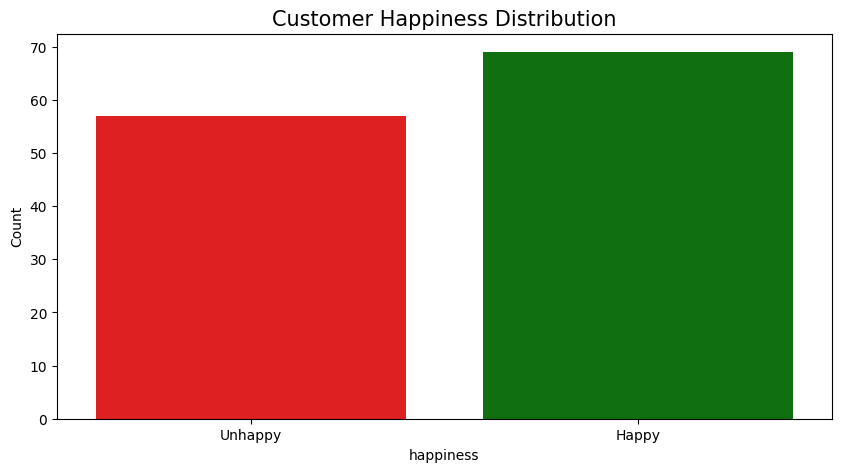

In [9]:
#plot outcome distribution
plt.figure(figsize=(10, 5))
# Define custom colors for 'Happy' and 'Unhappy'
custom_palette = {'0': 'red', '1': 'green'}
ax = sns.countplot(data=df, x=df.happiness, palette=custom_palette)
_ = plt.title('Customer Happiness Distribution', size=15)
# Changed code: updated xtick labels to reflect 0 & 1 mapping
_ = ax.set_xticklabels(['Unhappy', 'Happy'])
_ = plt.ylabel('Count')
_ = plt.show()

In [10]:
# create an array for happy and unhappy values to sample from
happy_array = happy_df.values
unhappy_array = unhappy_df.values
# create a boot to store happy customers at 100 iterations, choosing from the full range of the array
happy_boot = bootstrapping(happy_array, n_sample=len(happy_array), n_iters=100)

# create a boot to store unhappy customers at 100 iterations, choosing from the full range of the array
unhappy_boot = bootstrapping(unhappy_array, n_sample=len(unhappy_array), n_iters=100)

In [11]:
# set the new iteration to 57, the total number of unhappy customers
iters = 57

# set the sample to the length of either happy_boot or unhappy_boot.
# since both are equal it doesn't really matter, but we will test this to make sure.

if len(happy_boot) == len(unhappy_boot):
    sample = len(happy_boot)

# create a new list of happy customers from the boot we created
happy_customers = bootstrapping(happy_boot, sample, iters)

# create a new list of unhappy customers from the boot we created
unhappy_customers = bootstrapping(unhappy_boot, sample, iters)

# confirm length of each new list
print(f' Happy Customers: {len(happy_customers)}\n Unhappy Customers: {len(unhappy_customers)}')

 Happy Customers: 57
 Unhappy Customers: 57


In [12]:
# create a dataframe of happy customers
happy_df = pd.DataFrame(happy_customers, columns=df.columns)

# create a dataframe of unhappy customers
unhappy_df = pd.DataFrame(unhappy_customers, columns=df.columns)

#combine both dataframe into our new dataset
cleaned_df = pd.concat([happy_df, unhappy_df], axis=0).reset_index(drop=True)

<ipython-input-13-cc1357695c78>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=cleaned_df, x=cleaned_df.happiness,palette=custom_palette)
<ipython-input-13-cc1357695c78>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(['Unhappy', 'Happy'])


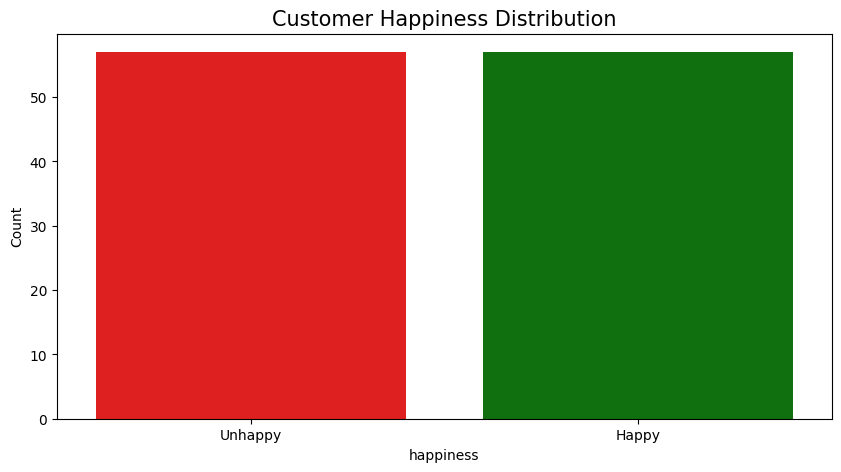

In [13]:
#plot outcome distribution
plt.figure(figsize=(10, 5))
custom_palette = {'0': 'red', '1': 'green'}
ax = sns.countplot(data=cleaned_df, x=cleaned_df.happiness,palette=custom_palette)
_ = plt.title('Customer Happiness Distribution', size=15)
_ = ax.set_xticklabels(['Unhappy', 'Happy'])
_ = plt.ylabel('Count')
_ = plt.show()

In [14]:
x = cleaned_df[['delivered_time', 'order_satisfaction', 'order_completed', 'price_satisfaction',
            'courier_satisfaction', 'app_satisfaction']]
display(x.head())
print(x.shape)

,delivered_time,order_satisfaction,order_completed,price_satisfaction,courier_satisfaction,app_satisfaction
0,5,5,4,4,4,4
1,4,3,3,1,3,3
2,4,4,3,3,3,3
3,4,4,2,4,3,2
4,1,5,5,1,1,5


(114, 6)


In [15]:
y = cleaned_df[['happiness']]
display(y.head())
print(y.shape)

,happiness
0,1
1,1
2,1
3,1
4,1


(114, 1)


# spliting and normalizing data

In [16]:
# split in training 80%, test 20% test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [17]:
# Normalizing data
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train -= mean
x_train /= std

x_test -= mean
x_test /= std

In [18]:
## checking the number of rows and columns in the X_train
print(f"The number of rows in the train data are {x_train.shape[0]}.")
print(f"The number of columns in the train data are {x_train.shape[1]}.")

The number of rows in the train data are 91.
The number of columns in the train data are 6.


In [19]:
## checking the number of rows and columns in the X_train
print(f"The number of rows in the train data are {x_test.shape[0]}.")
print(f"The number of columns in the train data are {x_test.shape[1]}.")

The number of rows in the train data are 23.
The number of columns in the train data are 6.


In [20]:
## checking the number of rows and columns in the X_train
print(f"The number of rows in the train data are {y_train.shape[0]}.")
print(f"The number of columns in the train data are {y_train.shape[1]}.")

The number of rows in the train data are 91.
The number of columns in the train data are 1.


In [21]:
## checking the number of rows and columns in the X_train
print(f"The number of rows in the train data are {y_test.shape[0]}.")
print(f"The number of columns in the train data are {y_test.shape[1]}.")

The number of rows in the train data are 23.
The number of columns in the train data are 1.


# training models

In [22]:
##creating SVM hyperparameter tuning

# Initialize the SVM model with a radial basis function kernel
svm_model = SVC(kernel='rbf', random_state=42)

# Train the SVM model
svm_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(x_test)

# Evaluate the svm_model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'degree': [3, 4, 5]  # Degree of the polynomial kernel function ('poly' only)
}

# Create SVM model
svm_model = SVC()

# Create GridSearchCV object
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_svm.fit(x_train, y_train)

# Get the best parameters and best score
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

# Calculate the mean and standard deviation of the cross-validation scores
mean_accuracy_svm = grid_search_svm.cv_results_['mean_test_score'].mean()
std_accuracy_svm = grid_search_svm.cv_results_['std_test_score'].mean()

# Output results
print(f"Average Accuracy: {mean_accuracy_svm:.4f}")
print(f"Standard Deviation: {std_accuracy_svm:.4f}")
print("Best Parameters:", best_params_svm)
print("Best Score:", best_score_svm)

Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.50      0.38      0.43         8

    accuracy                           0.65        23
   macro avg       0.60      0.59      0.59        23
weighted avg       0.63      0.65      0.64        23



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Average Accuracy: 0.6164
Standard Deviation: 0.1000
Best Parameters: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Best Score: 0.7578947368421053


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

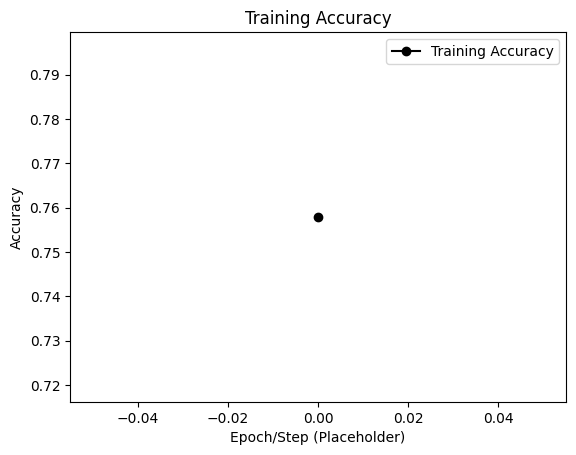

In [23]:
# Plot best score accuracy (as a single point)
plt.plot([0], [best_score_svm], marker='o', color='black', label='Training Accuracy')

plt.title('Training Accuracy')
plt.xlabel('Epoch/Step (Placeholder)')  # Placeholder x-axis
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
#creating voting classifier

# Create individual models
logreg = LogisticRegression(random_state=42)
svm = SVC(probability=True, random_state=42)  # 'probability=True' is needed for soft voting
dtree = DecisionTreeClassifier(random_state=42)

# Create a Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('svm', svm),
    ('dtree', dtree)
], voting='soft')  # 'soft' voting (using predicted probabilities)

# Train the voting classifier
voting_clf.fit(x_train, y_train)

# Make predictions on the test set
vc_pred = voting_clf.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print the classification report
print(classification_report(y_test, y_pred))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.50      0.38      0.43         8

    accuracy                           0.65        23
   macro avg       0.60      0.59      0.59        23
weighted avg       0.63      0.65      0.64        23



In [25]:
#creating Voting Classifier hyperparameter tuning

# Create individual models
logreg = LogisticRegression(random_state=42)
svm = SVC(probability=True, random_state=42)  # 'probability=True' is needed for soft voting
dtree = DecisionTreeClassifier(random_state=42)

# Create a Voting Classifier (soft voting uses predicted probabilities)
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('svm', svm),
    ('dtree', dtree)
], voting='soft')  # 'soft' voting (using predicted probabilities)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'logreg__C': [0.1, 1, 10],
    'logreg__solver': ['lbfgs', 'liblinear'],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto'],
    'dtree__max_depth': [None, 10, 20],
    'dtree__min_samples_split': [2, 5],
    'dtree__min_samples_leaf': [1, 2]
}

# Create GridSearchCV object
grid_search_vc = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Train the grid search
grid_search_vc.fit(x_train, y_train)

# Get the best parameters and best score
best_params = grid_search_vc.best_params_
best_score = grid_search_vc.best_score_

# Get predictions using the best model
vc_pred = grid_search_vc.best_estimator_.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, vc_pred)
print(f"Best Accuracy: {best_score:.2f}")
print(f"Best Parameters: {best_params}")
print(f"Test Accuracy: {accuracy:.2f}")

# Print the classification report
print(classification_report(y_test, vc_pred))


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was pass

Best Accuracy: 0.79
Best Parameters: {'dtree__max_depth': None, 'dtree__min_samples_leaf': 2, 'dtree__min_samples_split': 5, 'logreg__C': 0.1, 'logreg__solver': 'lbfgs', 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Test Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.64      0.88      0.74         8

    accuracy                           0.78        23
   macro avg       0.78      0.80      0.78        23
weighted avg       0.82      0.78      0.79        23



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


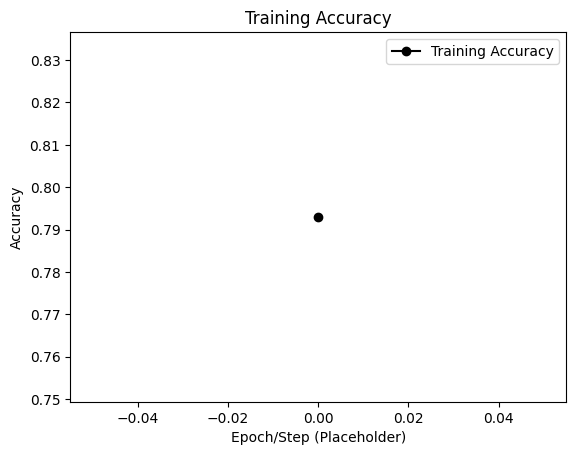

In [26]:
# Plot voting_clf best score accuracy (as a single point)
plt.plot([0], [best_score], marker='o', color='black', label='Training Accuracy')

plt.title('Training Accuracy')
plt.xlabel('Epoch/Step (Placeholder)')  # Placeholder x-axis
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
## Train Random Forest Classifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train,y_train)
# Perform cross-validation (e.g., 5-fold)
cv_scores = cross_val_score(rf_model, x_train, y_train, cv=5, scoring='accuracy')

# Calculate the average accuracy and standard deviation
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)


# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_rf.fit(x_train, y_train)

# Get the best parameters and best score
best_params = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f"Average Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")
print("Best Parameters:", best_params)
print("Best Score:", best_score_rf)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Average Accuracy: 0.8246
Standard Deviation: 0.0527
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.8467836257309941


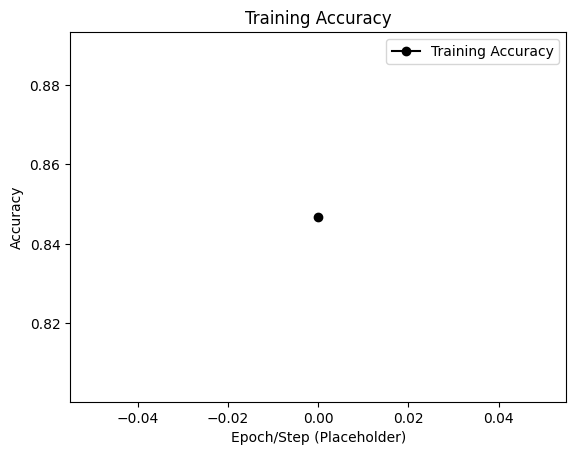

In [28]:
# Plot rf best score accuracy (as a single point)
plt.plot([0], [best_score_rf], marker='o', color='black', label='Training Accuracy')

plt.title('Training Accuracy')
plt.xlabel('Epoch/Step (Placeholder)')  # Placeholder x-axis
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# combinig the three models into a new Logistic Regression model

In [30]:
# frist get Predictions our models Using its best_estimator_
svm_pred_train = grid_search_svm.best_estimator_.predict(x_train)
svm_pred_test = grid_search_svm.best_estimator_.predict(x_test)

vc_pred_train = grid_search_vc.best_estimator_.predict(x_train)
vc_pred_test = grid_search_vc.best_estimator_.predict(x_test)

rf_pred_train =  grid_search_rf.best_estimator_.predict(x_train)
rf_pred_test = grid_search_rf.best_estimator_.predict(x_test)


In [31]:
# Combine Predictions as Features
# We will use predictions from both models as features for a final model
data_train_combined = np.column_stack((svm_pred_train,rf_pred_train,vc_pred_train))
data_test_combined = np.column_stack((svm_pred_test,rf_pred_test,vc_pred_test))

In [32]:
# 5. Train a final classifier using the combined features
final_model = LogisticRegression(random_state=32)
final_model.fit(data_train_combined, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=32)

In [33]:
#  Make final predictions
final_pred = final_model.predict(data_test_combined)

# The Evaluation of the final model

In [34]:
# 7. Evaluate the model
accuracy = accuracy_score(y_test, final_pred)
print(f"combined Models Accuracy: {accuracy:.4f}")

combined Models Accuracy: 0.9130


 # Most important feature

when predicting a cutomers happines we foud that the most important features affected is price satisfaction while the courier satisfaction have the minimal affect

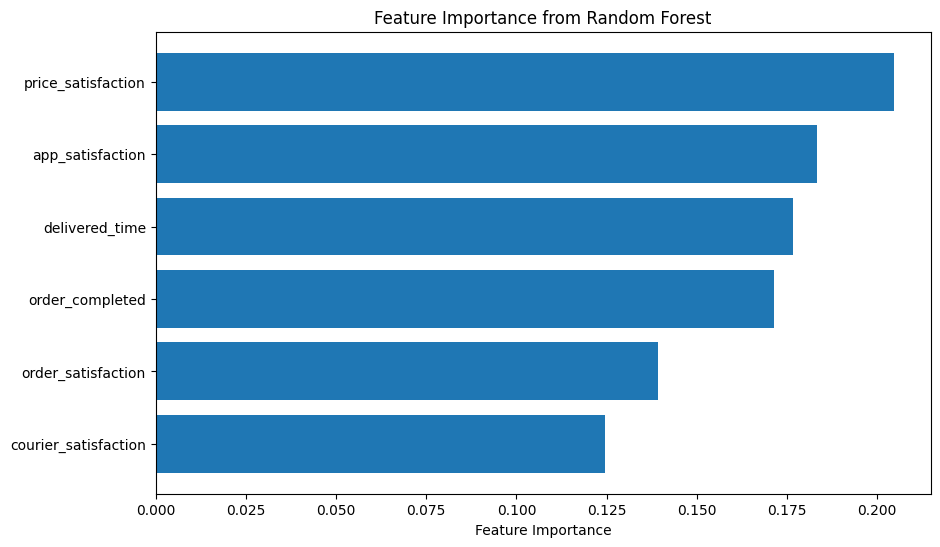

In [29]:
 # Feature importances from the Random Forest model
importances = rf_model.feature_importances_

# Sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Get feature names from x_train (assuming x_train is a pandas DataFrame)
feature_names = x_train.columns if hasattr(x_train, 'columns') else [f'Feature {i}' for i in range(x_train.shape[1])]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), np.array(feature_names)[indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

# conclusion

In conclusion the Random Forest was the best model using the data set with all features. It had the highest train and test accuracy. It also had the highest classification scores with both unhappy and happy customers getting a score of 84%

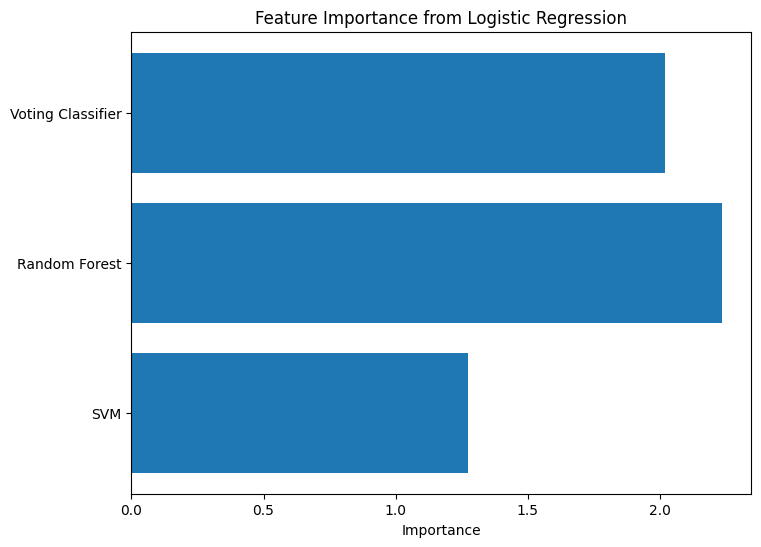

In [35]:
# Assuming final_model is your Logistic Regression model
importances = np.abs(final_model.coef_[0])  # Coefficients of the logistic regression model
features = ['SVM', 'Random Forest', 'Voting Classifier']

# Plotting the feature importance
plt.figure(figsize=(8, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Feature Importance from Logistic Regression')
plt.show()